In [1]:
import argparse
import os
import random
import shutil
import time
import warnings
import sys
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.utils.model_zoo as model_zoo
import torchvision
import torch.optim.lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler

from PIL import Image

In [2]:
BATCH_SIZE = 20
EPOCH = 50
GAMMA = 0.9
STEP_SIZE = 200
LR = 0.001
USE_GPU = True
decoder = ['buoy', 'dock', 'light_buoy', 'totem']
data_transform = transforms.Compose([
            transforms.Resize(227),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

In [53]:
list_path = '/media/arg_ws3/TOSHIBA EXT/data/trajectory/root.txt'
img_path = '/media/arg_ws3/TOSHIBA EXT/data/trajectory/images/'
ann_path = '/media/arg_ws3/TOSHIBA EXT/data/trajectory/annotations/'
model_path = '../model'
if not os.path.exists(model_path):
    os.makedirs(model_path)
data_list_file = open(list_path,'r')
raw_data_list = data_list_file.read().splitlines()
data_list = []
for data in raw_data_list:
    data_split = data.split(',')
    first_frame = data_split[0]
    data_len = int(data_split[1])
    if data_len >= 10:
        data_list.append([first_frame, data_len])

## Define Layer Modules

In [4]:
class LRN(nn.Module):
    def __init__(self, local_size=1, alpha=1.0, beta=0.75, ACROSS_CHANNELS=True):
        super(LRN, self).__init__()
        self.ACROSS_CHANNELS = ACROSS_CHANNELS
        if ACROSS_CHANNELS:
            self.average=nn.AvgPool3d(kernel_size=(local_size, 1, 1),
                    stride=1,
                    padding=(int((local_size-1.0)/2), 0, 0))
        else:
            self.average=nn.AvgPool2d(kernel_size=local_size,
                    stride=1,
                    padding=int((local_size-1.0)/2))
        self.alpha = alpha
        self.beta = beta


    def forward(self, x):
        if self.ACROSS_CHANNELS:
            div = x.pow(2).unsqueeze(1)
            div = self.average(div).squeeze(1)
            div = div.mul(self.alpha).add(1.0).pow(self.beta)
        else:
            div = x.pow(2)
            div = self.average(div)
            div = div.mul(self.alpha).add(1.0).pow(self.beta)
        x = x.div(div)
        return x
    
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class alexnet_conv_layers(nn.Module):
    def __init__(self):
        super(alexnet_conv_layers, self).__init__()
        self.base_features = torchvision.models.alexnet(pretrained = True).features
        self.skip1 = nn.Sequential(
            nn.Conv2d(64, out_channels=16, kernel_size=1, stride=1),
            nn.PReLU(),
            Flatten()
        )
        self.skip2 = nn.Sequential(
            nn.Conv2d(192, out_channels=32, kernel_size=1, stride=1),
            nn.PReLU(),
            Flatten()
        )
        self.skip5 = nn.Sequential(
            nn.Conv2d(256, out_channels=64, kernel_size=1, stride=1),
            nn.PReLU(),
            Flatten()
        )
        self.conv6 = nn.Sequential(
            nn.Linear(37104 * 2, 2048),
            nn.ReLU()
        )
        
        # Freeze those weights
        for p in self.base_features.parameters():
            p.requires_grad = False
            
    def forward(self, x, y):
        layer_extractor_x = []
        layer_extractor_y = []
        for idx, model in enumerate(self.base_features):
            x = model(x)
            y = model(y)
            if idx in {2, 5, 11}: # layer output of conv1, conv2 , conv5(before pooling layer)
                layer_extractor_x.append(x)
                layer_extractor_y.append(y)
                
        x_out_flat = x.view(1, -1) #(1, 256, 6, 6) --> (1, 9216)
        x_out_skip1 = self.skip1(layer_extractor_x[0]) #(1, 64, 27, 27) -> (11664)
        x_out_skip2 = self.skip2(layer_extractor_x[1]) #(1, 192, 13, 13) -> (5408)
        x_out_skip5 = self.skip5(layer_extractor_x[2]) #(1, 256, 13, 13) -> (10816)
        x_out = torch.cat((x_out_skip1, x_out_skip2, x_out_skip5, x_out_flat), dim=1)
        
        y_out_flat = y.view(1, -1) #(1, 256, 6, 6) --> (1, 9216)
        y_out_skip1 = self.skip1(layer_extractor_y[0]) #(1, 64, 27, 27) -> (11664)
        y_out_skip2 = self.skip2(layer_extractor_y[1]) #(1, 192, 13, 13) -> (5408)
        y_out_skip5 = self.skip5(layer_extractor_y[2]) #(1, 256, 13, 13) -> (10816)
        y_out = torch.cat((y_out_skip1, y_out_skip2, y_out_skip5, y_out_flat), dim=1)
        
        final_out = torch.cat((x_out, y_out), dim=1)
        conv_out = self.conv6(final_out) # (1, 2048)
        return conv_out

In [5]:
class PredictNet(nn.Module):
    def __init__(self):
        super(Re3Net,self).__init__()
        self.conv_layers = alexnet_conv_layers()
        
        #2048 from conv_layers? maybe 1024?
        self.lstm1 =nn.LSTMCell(2048, LSTM_SIZE)
        self.lstm2 = nn.LSTMCell(2048 + LSTM_SIZE, LSTM_SIZE)

        self.fc_final = nn.Linear(LSTM_SIZE,4)
        
        self.h1 = Variable(torch.rand(1, LSTM_SIZE)).cuda()
        self.c1 = Variable(torch.rand(1, LSTM_SIZE)).cuda()
        
        self.h2 = Variable(torch.rand(1, LSTM_SIZE)).cuda()
        self.c2 = Variable(torch.rand(1, LSTM_SIZE)).cuda()

    def init_hidden(self):
        self.h1 = Variable(torch.rand(1, LSTM_SIZE)).cuda()
        self.c1 = Variable(torch.rand(1, LSTM_SIZE)).cuda()
        
        self.h2 = Variable(torch.rand(1, LSTM_SIZE)).cuda()
        self.c2 = Variable(torch.rand(1, LSTM_SIZE)).cuda()

    def detach_hidden(self):
        self.h1 = self.h1.detach()
        self.c1 = self.c1.detach()
        
        self.h2 = self.h2.detach()
        self.c2 = self.c2.detach()

    def forward(self, x, y):
        out = self.conv_layers(x, y)

        lstm1_out, self.h1 = self.lstm1(out, (self.h1, self.c1))

        lstm2_in = torch.cat((out, lstm1_out), dim=1)

        lstm2_out, self.h2 = self.lstm2(lstm2_in, (self.h2, self.c2))

        out = self.fc_final(lstm2_out)
        return out

In [62]:
next_frame = 'stage4_1733'
frame_num = 20
for frame_num in range(frame_num):
    file = open(ann_path + next_frame + '.txt','r')
    file_split = file.read().splitlines()
    print(ann_path + next_frame + '.txt', file_split[0])
    next_frame = file_split[1]

/media/arg_ws3/TOSHIBA EXT/data/trajectory/annotations/stage4_1733.txt True
/media/arg_ws3/TOSHIBA EXT/data/trajectory/annotations/stage4_1734.txt False
/media/arg_ws3/TOSHIBA EXT/data/trajectory/annotations/stage4_1735.txt False
/media/arg_ws3/TOSHIBA EXT/data/trajectory/annotations/stage4_1736.txt False
/media/arg_ws3/TOSHIBA EXT/data/trajectory/annotations/stage4_1737.txt False
/media/arg_ws3/TOSHIBA EXT/data/trajectory/annotations/stage4_1738.txt False
/media/arg_ws3/TOSHIBA EXT/data/trajectory/annotations/stage4_1739.txt False
/media/arg_ws3/TOSHIBA EXT/data/trajectory/annotations/stage4_1740.txt False
/media/arg_ws3/TOSHIBA EXT/data/trajectory/annotations/stage4_1741.txt False
/media/arg_ws3/TOSHIBA EXT/data/trajectory/annotations/stage4_1742.txt False
/media/arg_ws3/TOSHIBA EXT/data/trajectory/annotations/stage4_1743.txt False
/media/arg_ws3/TOSHIBA EXT/data/trajectory/annotations/stage4_1744.txt False
/media/arg_ws3/TOSHIBA EXT/data/trajectory/annotations/stage4_1745.txt False


In [73]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
img_transform = transforms.Compose([
                    transforms.RandomResizedCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    normalize,
                    ])
def train_model(num_epochs):
    for epoch in range(num_epochs):
        if epoch != 0 and epoch % 5 == 0:
            adjust_learning_rate(optim)
        curr_loss = 0.0
        dataset_size = len(data_list)
        sample_list = random.sample(range(0, dataset_size), dataset_size)
        for idx in sample_list:
            frame_name = data_list[idx][0]
            data_len = data_list[idx][1]
            for frame_num in range(data_len):
                file = open(ann_path + frame_name + '.txt','r')
                file_split = file.read().splitlines()
                next_frame = file_split[1]
                img = Image.open(img_path + next_frame + '.jpg')
                img = img.convert('RGB')
                img = img_transform(img)
                x = torch.tensor([float(file_split[4]) - float(file_split[2])])
                y = torch.tensor([float(file_split[5]) - float(file_split[3])])
                print(x.shape, y.shape)
                frame_name = next_frame
train_model(1)

torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Si

torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Si

torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Si

torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Si

torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Si

torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Si

torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Si

torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Si

torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Si

torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Si

torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Si

torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Si

torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Si

torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])
torch.Size([1]) torch.Size([1])


# Loading data

### Use torch ImageFolder

In [21]:
'''train_data = datasets.ImageFolder(root = img_path, \
                                transform = data_transform)'''

'''train_loader = torch.utils.data.DataLoader(dataset = train_data, \
                                batch_size = BATCH_SIZE, \
                                shuffle = True)'''

'train_loader = torch.utils.data.DataLoader(dataset = train_data,                                 batch_size = BATCH_SIZE,                                 shuffle = True)'

### Use custom dataset

In [6]:
MultiViewDst = MultiViewDataset(root = img_path,\
                            transform = data_transform)
decoder = MultiViewDst.classes
print(decoder)

['buoy', 'dock', 'light_buoy', 'totem']


In [7]:
'''MultiViewDst = MultiViewScaleDataset(root = img_path,\
                            transform = data_transform)
decoder = MultiViewDst.classes
print(decoder)'''

'MultiViewDst = MultiViewScaleDataset(root = img_path,                            transform = data_transform)\ndecoder = MultiViewDst.classes\nprint(decoder)'

### Splitting dataset to training & validation set

In [9]:
dataset_size = len(MultiViewDst) #3080 #2080
indices = list(range(dataset_size))
validation_split = .1
split = int(np.floor(validation_split * dataset_size))
np.random.seed(0)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
train_loader = torch.utils.data.DataLoader(dataset = MultiViewDst, \
                                batch_size = BATCH_SIZE, \
                                sampler = train_sampler)
train_size = len(train_indices)
validation_size = len(val_indices)
validation_loader = torch.utils.data.DataLoader(dataset = MultiViewDst, \
                                batch_size = validation_size, \
                                sampler = valid_sampler)
valid_iter = iter(validation_loader)
valid_data = next(valid_iter)
valid_y = valid_data[1].cuda()
print('Dataset size:', dataset_size)
print('train size:', train_size)
print('validation size:', validation_size)

Dataset size: 2060
train size: 1854
validation size: 206


In [10]:
def compute_accuracy_scale(model, validset, label):
    if USE_GPU:
        validset[0] = validset[0].cuda()
        scale = [x.cuda() for x in validset[2]]
    output = model(validset[0], scale)
    pred_y = torch.max(output, 1)[1].data.squeeze()
    accuracy = (pred_y == label).sum().item() / float(label.size(0))
    return accuracy

In [11]:
def compute_accuracy(model, validset, label):
    if USE_GPU:
        validset[0] = validset[0].cuda()
    output = model(validset[0])
    pred_y = torch.max(output, 1)[1].data.squeeze()
    accuracy = (pred_y == label).sum().item() / float(label.size(0))
    return accuracy

Epoch:  0 | train loss: 1.882532 | accuracy: 0.3883 | learning rate: 0.001000
Epoch:  1 | train loss: 0.023379 | accuracy: 0.9757 | learning rate: 0.001000
Epoch:  2 | train loss: 0.003961 | accuracy: 0.9757 | learning rate: 0.001000


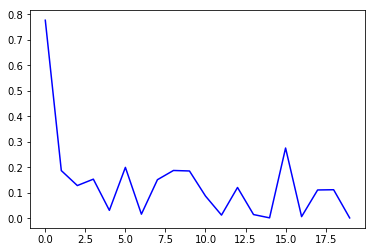

Epoch:  3 | train loss: 0.005428 | accuracy: 0.9757 | learning rate: 0.000900
Epoch:  4 | train loss: 0.089341 | accuracy: 0.9903 | learning rate: 0.000900


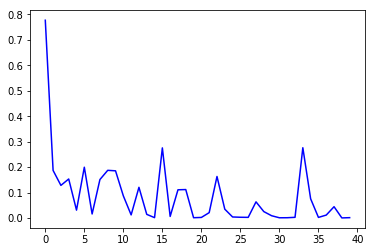

Epoch:  5 | train loss: 0.001783 | accuracy: 0.9806 | learning rate: 0.000810
Save net:  ./model/robotx_ch3_epoch5.pth
Epoch:  6 | train loss: 0.013708 | accuracy: 0.9757 | learning rate: 0.000810


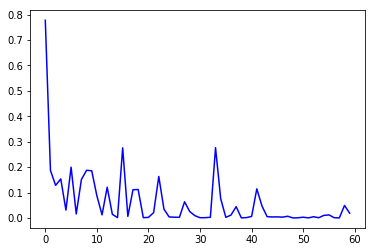

Epoch:  7 | train loss: 0.002582 | accuracy: 0.9757 | learning rate: 0.000729
Epoch:  8 | train loss: 0.000419 | accuracy: 0.9903 | learning rate: 0.000729


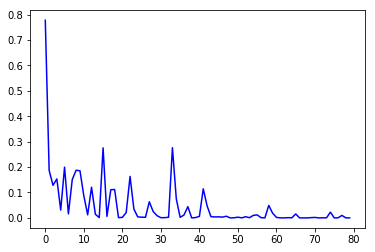

Epoch:  9 | train loss: 0.000022 | accuracy: 0.9854 | learning rate: 0.000656
Epoch:  10 | train loss: 0.033216 | accuracy: 0.9903 | learning rate: 0.000656


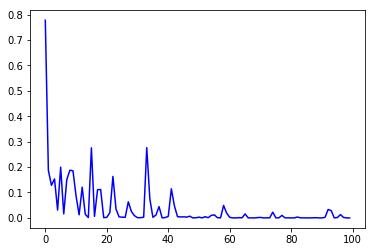

Save net:  ./model/robotx_ch3_epoch10.pth
Epoch:  11 | train loss: 0.000171 | accuracy: 0.9806 | learning rate: 0.000590
Epoch:  12 | train loss: 0.006270 | accuracy: 0.9951 | learning rate: 0.000590


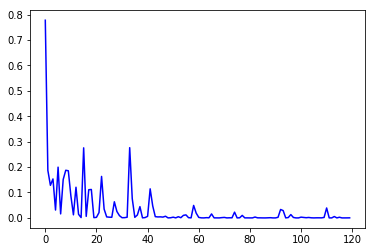

Epoch:  13 | train loss: 0.001982 | accuracy: 0.9854 | learning rate: 0.000531
Epoch:  14 | train loss: 0.000010 | accuracy: 0.9806 | learning rate: 0.000531
Epoch:  15 | train loss: 0.001760 | accuracy: 0.9854 | learning rate: 0.000531


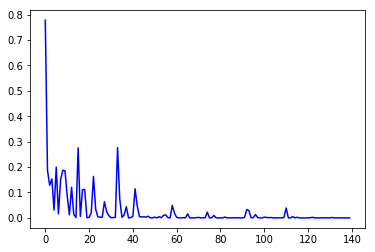

Save net:  ./model/robotx_ch3_epoch15.pth
Epoch:  16 | train loss: 0.000005 | accuracy: 0.9854 | learning rate: 0.000478
Epoch:  17 | train loss: 0.000003 | accuracy: 0.9854 | learning rate: 0.000478


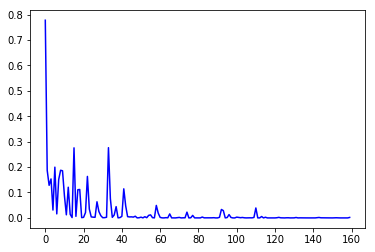

Epoch:  18 | train loss: 0.000006 | accuracy: 0.9854 | learning rate: 0.000430
Epoch:  19 | train loss: 0.000013 | accuracy: 0.9854 | learning rate: 0.000430


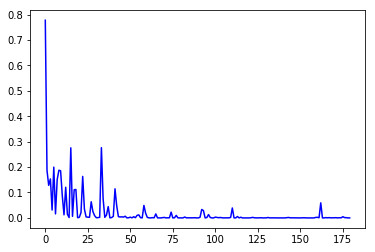

Epoch:  20 | train loss: 0.000029 | accuracy: 0.9903 | learning rate: 0.000387
Save net:  ./model/robotx_ch3_epoch20.pth
Epoch:  21 | train loss: 0.000295 | accuracy: 0.9854 | learning rate: 0.000387


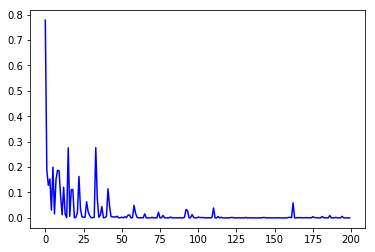

Epoch:  22 | train loss: 0.000023 | accuracy: 0.9854 | learning rate: 0.000349
Epoch:  23 | train loss: 0.000079 | accuracy: 0.9854 | learning rate: 0.000349


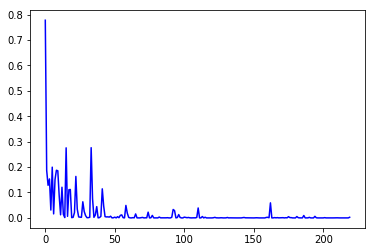

Epoch:  24 | train loss: 0.005055 | accuracy: 0.9854 | learning rate: 0.000314
Epoch:  25 | train loss: 0.000213 | accuracy: 0.9806 | learning rate: 0.000314


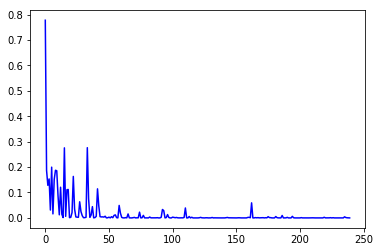

Save net:  ./model/robotx_ch3_epoch25.pth
Epoch:  26 | train loss: 0.000084 | accuracy: 0.9854 | learning rate: 0.000282
Epoch:  27 | train loss: 0.000025 | accuracy: 0.9854 | learning rate: 0.000282


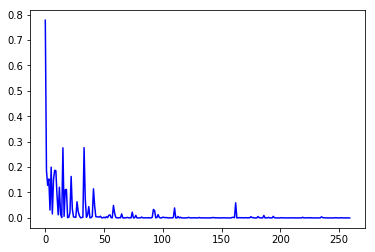

Epoch:  28 | train loss: 0.000018 | accuracy: 0.9903 | learning rate: 0.000254
Epoch:  29 | train loss: 0.000003 | accuracy: 0.9854 | learning rate: 0.000254
Epoch:  30 | train loss: 0.000113 | accuracy: 0.9806 | learning rate: 0.000254


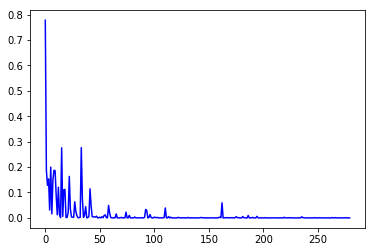

Save net:  ./model/robotx_ch3_epoch30.pth
Epoch:  31 | train loss: 0.000049 | accuracy: 0.9854 | learning rate: 0.000229
Epoch:  32 | train loss: 0.000571 | accuracy: 0.9903 | learning rate: 0.000229


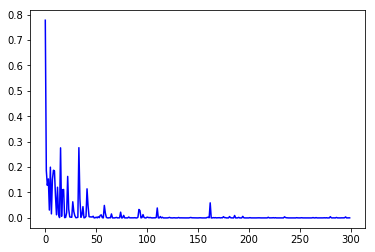

Epoch:  33 | train loss: 0.000015 | accuracy: 0.9854 | learning rate: 0.000206
Epoch:  34 | train loss: 0.000064 | accuracy: 0.9903 | learning rate: 0.000206


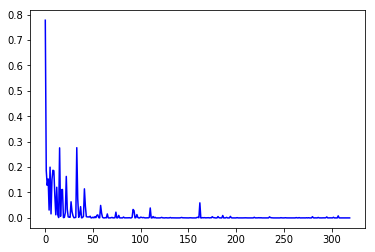

Epoch:  35 | train loss: 0.000136 | accuracy: 0.9854 | learning rate: 0.000185
Save net:  ./model/robotx_ch3_epoch35.pth
Epoch:  36 | train loss: 0.000765 | accuracy: 0.9806 | learning rate: 0.000185


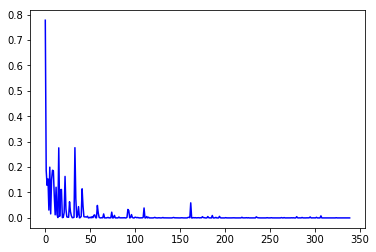

Epoch:  37 | train loss: 0.000093 | accuracy: 0.9854 | learning rate: 0.000167
Epoch:  38 | train loss: 0.000037 | accuracy: 0.9806 | learning rate: 0.000167


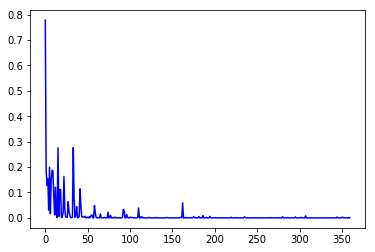

Epoch:  39 | train loss: 0.000152 | accuracy: 0.9806 | learning rate: 0.000150
Epoch:  40 | train loss: 0.000001 | accuracy: 0.9854 | learning rate: 0.000150


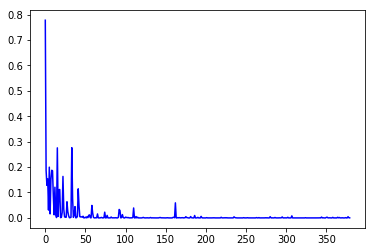

Save net:  ./model/robotx_ch3_epoch40.pth
Epoch:  41 | train loss: 0.000987 | accuracy: 0.9806 | learning rate: 0.000135
Epoch:  42 | train loss: 0.000006 | accuracy: 0.9854 | learning rate: 0.000135
Epoch:  43 | train loss: 0.000103 | accuracy: 0.9854 | learning rate: 0.000135


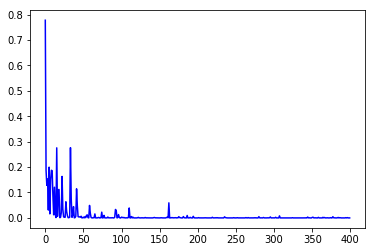

Epoch:  44 | train loss: 0.002121 | accuracy: 0.9854 | learning rate: 0.000122
Epoch:  45 | train loss: 0.000160 | accuracy: 0.9854 | learning rate: 0.000122


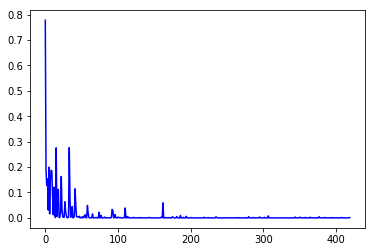

Save net:  ./model/robotx_ch3_epoch45.pth
Epoch:  46 | train loss: 0.000033 | accuracy: 0.9903 | learning rate: 0.000109
Epoch:  47 | train loss: 0.000006 | accuracy: 0.9854 | learning rate: 0.000109


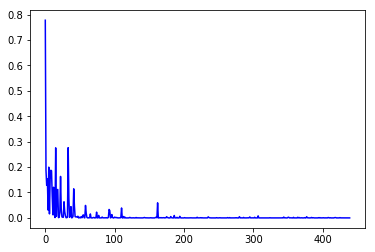

Epoch:  48 | train loss: 0.000007 | accuracy: 0.9854 | learning rate: 0.000098
Epoch:  49 | train loss: 0.000021 | accuracy: 0.9854 | learning rate: 0.000098


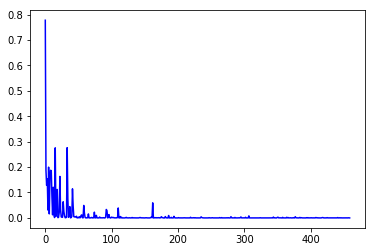

Finish


In [19]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
count = 0
loss_values = []
lr = LR
for epoch in range(EPOCH):
    #for step, (b_x, b_y, b_scale) in enumerate(train_loader):
    for step, (b_x, b_y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        if USE_GPU:
            b_x = b_x.cuda()
            b_y = b_y.cuda()
            
        '''if USE_GPU:
            b_x = b_x.cuda()
            b_y = b_y.cuda()
            b_scale = [x.cuda() for x in b_scale]'''
        
        #output = multiviewnet(b_x, b_scale)  # cnn output
        output = alexnet(b_x)  # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients
        #scheduler.step()                # dynamic learning rate
        
        if count % STEP_SIZE == 0 and count != 0:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= GAMMA
                lr = param_group['lr']
        
        if step % 100 == 0:
            #accuracy = compute_accuracy_scale(multiviewnet, valid_data, valid_y)
            accuracy = compute_accuracy(alexnet, valid_data, valid_y)
            print('Epoch: ', epoch, '| train loss: %.6f' % loss.cpu().data.numpy(), \
                  '| accuracy: %.4f' % accuracy, \
                  '| learning rate: %.6f' % lr)
        if count % 10 == 0 and count != 0:
            loss_values.append(loss.item())
        if count % 200 == 0 and count != 0:
            plt.plot(loss_values, '-b', label='loss')
            plt.show()
        count = count + 1
    if epoch % 5 == 0 and epoch != 0:
        PATH = model_path + '/robotx_ch3_epoch' + str(epoch) + '.pth'
        #torch.save(multiviewnet.state_dict(), PATH)
        torch.save(alexnet.state_dict(), PATH)
        print("Save net: ", PATH)
print("Finish")

In [ ]:
alexnet.load_state_dict(torch.load('../model/robotx_ch3_epoch25.pth'))
alexnet.eval()
#alexnet = torch.load('./robotx_ch3.pth')
#alexnet.eval()

In [28]:
show_loader = torch.utils.data.DataLoader(dataset = MultiViewDst, \
                                batch_size = 1, \
                                sampler = valid_sampler)
show_iter = iter(show_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 227, 227])
Prediction:  dock
Label:  dock
Image shape:  (227, 227, 3)


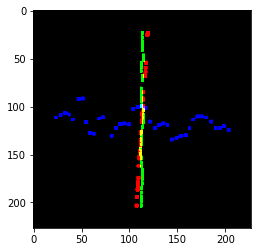

In [33]:
data = next(show_iter)
img = data[0][0].numpy()
torch_img = np.expand_dims(img, axis=0)
x = torch.tensor(torch_img).type('torch.FloatTensor').cuda()
output = alexnet(x)
print(x.shape)
pred_y = torch.max(output, 1)[1].cpu().data.numpy()
print('Prediction: ', decoder[int(pred_y)])

print('Label: ', decoder[data[1][0].numpy()])
#img = img[:][:]
#img = np.squeeze(img)
cv_img = np.transpose(img, (1, 2, 0))
print('Image shape: ', cv_img.shape)
plt.imshow(cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 227, 227)
torch.Size([1, 3, 227, 227])
[tensor([[14.5140]], device='cuda:0'), tensor([[12.1839]], device='cuda:0'), tensor([[12.1839]], device='cuda:0')]
Prediction:  totem
Label:  totem
Image shape:  (227, 227, 3)


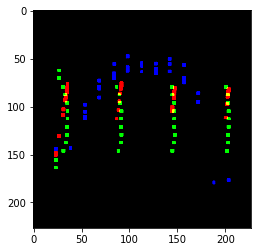

In [43]:
data = next(show_iter)
img = data[0][0].numpy()
print(img.shape)
torch_img = np.expand_dims(img, axis=0)
x = torch.tensor(torch_img).type('torch.FloatTensor').cuda()
print(x.shape)
scalar_data = [i.cuda() for i in data[2]]
output = multiviewnet(x, scalar_data)
print(scalar_data)
pred_y = torch.max(output, 1)[1].cpu().data.numpy()
print('Prediction: ', decoder[int(pred_y)])

print('Label: ', decoder[data[1][0].numpy()])
#img = img[:][:]
#img = np.squeeze(img)
cv_img = np.transpose(img, (1, 2, 0))
print('Image shape: ', cv_img.shape)
plt.imshow(cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB))

In [96]:
torch.save(multiviewnet, '../model_scale/robotx_final.pth')

/usr/local/lib/python3.5/dist-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type MultiViewNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
